https://www.datatrigger.org/post/nlp_hugging_face/

In [6]:
%%capture
!pip install transformers

In [7]:
# transformers 4.20.1 in this notebook
from transformers import pipeline

# By default, the pipeline runs on the CPU (device=-1). Set device to 0 to use the GPU (and to 1 for the second GPU, etc...)
classifier = pipeline("zero-shot-classification", device=0)
classifier(
    "Parallel processing with GPUs is the savior of Deep Learning",
    candidate_labels=["education", "politics", "technology"],
)

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


{'sequence': 'Parallel processing with GPUs is the savior of Deep Learning',
 'labels': ['technology', 'education', 'politics'],
 'scores': [0.9941806197166443, 0.0031009113881736994, 0.002718453062698245]}

In [9]:
#!unzip '/content/bbc-fulltext.zip'

In [11]:
# Utilities to handle directories, files, paths, etc...
from os import listdir
from os.path import isdir, isfile, join
from pathlib import Path

# Most original import ever
import pandas as pd

path_to_bbc_articles="bbc"
labels=[] # labels for the text classification
label_dataframes=[] # for each label, get the articles into a dataframe

for label in [dir for dir in listdir(path_to_bbc_articles) if isdir(join(path_to_bbc_articles, dir)) and dir!=".ipynb_checkpoints"]:
    labels.append(label)
    label_path=join(path_to_bbc_articles, label)
    articles_list=[]
    for article_file in [file for file in listdir(label_path) if isfile(join(label_path, file))]:
        article_path=join(label_path, article_file)
        article=Path(article_path).read_text(encoding="ISO-8859-1") # Tried utf-8 (of course) but encountered error
        # Stackoverflow said "try ISO-8859-1", it worked (dataset is 11 years old)
        articles_list.append(article)
    label_dataframes.append(pd.DataFrame({'label': label, 'article': articles_list}))
    
df=pd.concat(label_dataframes, ignore_index=True) # Concatenate all the dataframes


In [12]:
df.value_counts('label')

label
sport            511
business         510
politics         417
tech             401
entertainment    386
dtype: int64

In [14]:
df['label_int']=df['label'].apply(lambda x:labels.index(x))

In [15]:
df.head()

,label,article,label_int
0,tech,Learning to love broadband\n\nWe are reaching ...,0
1,tech,Rings of steel combat net attacks\n\nGambling ...,0
2,tech,The Force is strong in Battlefront\n\nThe warm...,0
3,tech,UK net users leading TV downloads\n\nBritish T...,0
4,tech,US peer-to-peer pirates convicted\n\nThe first...,0


## II) Fine-tuning a pretrained text classifier
After building the train/validation/test sets, we will go straight the point by using the DistilBERT pre-trained transformer model (and its tokenizer).

It is a small, fast, cheap and light Transformer model trained by distilling BERT base. It has 40% less parameters than bert-base-uncased, runs 60% faster while preserving over 95% of BERT’s performances.

In [16]:
# Train set, validation set and test set
from sklearn.model_selection import train_test_split

train_val, test = train_test_split(df, test_size=0.1, random_state=42, shuffle=True)
train, val = train_test_split(train_val, test_size=0.2, random_state=42, shuffle=True)

# Reset the indexes of the 3 pandas.DataFrame()
train, val, test = map(lambda x:x.reset_index(drop=True), [train, val, test])


#Tokenize
Loading DistilBERT’s tokenizer, we can see that this transformer model takes input sequences composed of up to 512 tokens:

In [17]:
# Load Distilbert's tokenizer
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
tokenizer.max_model_input_sizes

{'distilbert-base-uncased': 512,
 'distilbert-base-uncased-distilled-squad': 512,
 'distilbert-base-cased': 512,
 'distilbert-base-cased-distilled-squad': 512,
 'distilbert-base-german-cased': 512,
 'distilbert-base-multilingual-cased': 512}

How does this compare with the lengths of the tokenized BBC articles?

In [18]:
tokenized_articles_lengths=pd.DataFrame({'length': list(map(len, tokenizer(df['article'].to_list(), truncation=False, padding=False)['input_ids']))})
tokenized_articles_lengths.describe()

Token indices sequence length is longer than the specified maximum sequence length for this model (912 > 512). Running this sequence through the model will result in indexing errors


,length
count,2225.000000
mean,487.627416
std,293.625901
min,108.000000
25%,314.000000
50%,423.000000
75%,592.000000
max,5303.000000


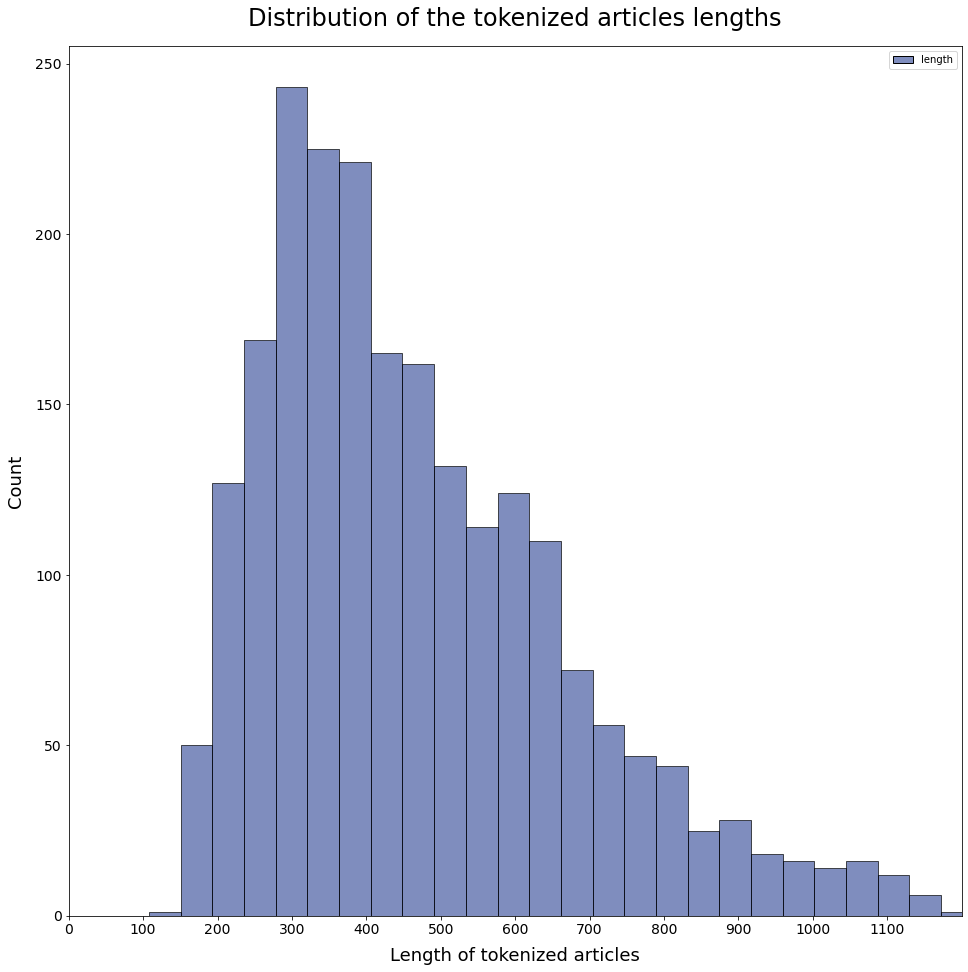

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Fast less good-looking plot
# ax=sns.histplot(tokenized_articles_lengths)
# ax.set(xlabel='Length of tokenized articles', ylabel='Count', xlim=(0, 1200), title='Distribution of the # tokenized articles lengths')
# plt.show()

fig, ax = plt.subplots(figsize=(16, 16))
ax=sns.histplot(tokenized_articles_lengths, palette='dark')
ax.set(xlim=(0, 1200))
ax.set_xticks(range(0, 1200, 100))
ax.set_title('Distribution of the tokenized articles lengths', fontsize=24, pad=20)
ax.set_xlabel('Length of tokenized articles', fontsize = 18, labelpad = 10)
ax.set_ylabel('Count', fontsize = 18, labelpad = 10)
ax.tick_params(labelsize=14)
plt.savefig('tokenized_articles_length_distribution.png', bbox_inches='tight');

In [20]:
from scipy.stats import percentileofscore
print(f'Percentile of length=512: {int(percentileofscore(tokenized_articles_lengths["length"],512))}th')

Percentile of length=512: 64th


About 36% of the articles will be truncated to fit the 512-token limit of DistilBERT. The truncation is mandatory, otherwise the model crashes. We will use fixed padding for the sake of simplicity here.

In [21]:
# Format the train/validation/test sets
train_encodings = tokenizer(train['article'].to_list(), truncation=True, padding=True)
val_encodings = tokenizer(val['article'].to_list(), truncation=True, padding=True)
test_encodings = tokenizer(test['article'].to_list(), truncation=True, padding=True)

import torch

class BBC_Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = BBC_Dataset(train_encodings, train['label_int'].to_list())
val_dataset = BBC_Dataset(val_encodings, val['label_int'].to_list())
test_dataset = BBC_Dataset(test_encodings, test['label_int'].to_list())


# Fine-tuning
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=4,
    weight_decay=0.01,
)

# The number of predicted labels must be specified with num_labels
# .to('cuda') to do the training on the GPU
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(labels)).to('cuda')

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classi

In [22]:
trainer.train()
trainer.save_model("bbc_news_model")
1
2
# Generate predictions for the test set
predictions=trainer.predict(test_dataset)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1601
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 603


Step,Training Loss
500,0.143600


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to bbc_news_model
Configuration saved in bbc_news_model/config.json
Model weights saved in bbc_news_model/pytorch_model.bin
***** Running Prediction *****
  Num examples = 223
  Batch size = 4


In [24]:
import numpy as np

In [25]:
test_results=test.copy(deep=True)
test_results["label_int_pred_transfer_learning"]=np.argmax(predictions.predictions, axis=-1)
test_results['label_pred_transfer_learning']=test_results['label_int_pred_transfer_learning'].apply(lambda x:labels[x])
accuracy=1-(len(test_results[test_results["label"]!=test_results["label_pred_transfer_learning"]])/len(test_results))

In [26]:
accuracy=1-(len(test_results[test_results["label"]!=test_results["label_pred_transfer_learning"]])/len(test_results))
print(f'The accuracy of the fine-tuned DistilBERT transformer model on the test set is {100*accuracy:.2f}%.')

The accuracy of the fine-tuned DistilBERT transformer model on the test set is 98.21%.


#Misclassified articles

In [27]:
with pd.option_context('display.max_colwidth', None):
    display(test_results[test_results["label"]!=test_results["label_pred_transfer_learning"]])


label  \
49   business   
67       tech   
103      tech   
216  business   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

#III) Zero-Shot Classification
We'll use the appropriate transformers.pipeline to compute the predicted class for each article.

In [28]:
from transformers import pipeline
classifier = pipeline("zero-shot-classification", device=0) # device=0 means GPU

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.
loading configuration file https://huggingface.co/facebook/bart-large-mnli/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/980f2be6bd282c5079e99199d7554cfd13000433ed0fdc527e7def799e5738fe.4fdc7ce6768977d347b32986aff152e26fcebbda34ef89ac9b114971d0342e09
Model config BartConfig {
  "_name_or_path": "facebook/bart-large-mnli",
  "_num_labels": 3,
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_final_layer_norm": false,
  "architectures": [
    "BartForSequenceClassification"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 12,
  "d

In [29]:
test_results.head()

,label,article,label_int,label_int_pred_transfer_learning,label_pred_transfer_learning
0,entertainment,Little Britain two top comic list\n\nLittle Br...,1,1,entertainment
1,entertainment,Buffy creator joins Wonder Woman\n\nThe creato...,1,1,entertainment
2,sport,Juninho demand for O'Neill talks\n\nJuninho's ...,3,3,sport
3,entertainment,Potter director signs Warner deal\n\nHarry Pot...,1,1,entertainment
4,sport,Campbell to be Lions consultant\n\nFormer gove...,3,3,sport


In [30]:
# Compute the predicted label for each article
test_results['label_pred_zero_shot']=test_results['article'].apply(lambda x:classifier(x, candidate_labels=labels)['labels'][0])

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/base.py:1039: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,


In [31]:
# Reorder columns and save results
test_results=test_results[['article', 'label', 'label_pred_transfer_learning', 'label_pred_zero_shot']]
test_results.to_parquet("test_results.parquet")

In [32]:
test_results=pd.read_parquet("test_results.parquet")

In [33]:
error_rate=len(test_results[test_results["label"]!=test_results["label_pred_zero_shot"]])/len(test_results)
print(f'Accuracy of the Zero-Shot classifier: {round(100*(1-error_rate), 2)} %')

Accuracy of the Zero-Shot classifier: 52.47 %


The Zero-Shot classifier does a really bad job compared with the fine-tuned model. However, given the number of labels — 5 — this result is not that catastrophic. It is well above the 20% a random classifier would achieve (assuming balanced classes). Let's have a look at a few random articles uncorrectly labeled by the Zero-Shot classifier:

In [34]:
test_results[test_results["label"]!=test_results["label_pred_zero_shot"]].sample(15, random_state=42)

,article,label,label_pred_transfer_learning,label_pred_zero_shot
194,Dollar slides ahead of New Year\n\nThe US doll...,business,business,politics
16,Khodorkovsky ally denies charges\n\nA close as...,business,business,politics
8,De Niro film leads US box office\n\nFilm star ...,entertainment,entertainment,business
154,Budget Aston takes on Porsche\n\nBritish car m...,business,business,sport
190,Why Cell will get the hard sell\n\nThe world i...,tech,tech,entertainment
116,Godzilla gets Hollywood fame star\n\nMovie mon...,entertainment,entertainment,tech
53,File-swappers ready new network\n\nLegal attac...,tech,tech,business
60,Rolling out next generation's net\n\nThe body ...,tech,tech,entertainment
183,Council tax rise 'reasonable'\n\nWelsh council...,politics,politics,business
17,Cage film's third week at US top\n\nNicolas Ca...,entertainment,entertainment,business


There does not seem to be a particularly problematic class, although such a assertion would require further investigation. But the length of the news could lead to poor performance. We can read about this on the 🤗 Hugging Face forum. Joe Davison, 🤗 Hugging Face developer and creator of the Zero-Shot pipeline, says the following:

For long documents, I don’t think there’s an ideal solution right now. If truncation isn’t satisfactory, then the best thing you can do is probably split the document into smaller segments and ensemble the scores somehow.

We'll try another solution: summarizing the article first, then Zero-Shot classifying it.

#IV) Summarization + Zero-Shot Classification
The easiest way to do this would have been to line up the SummarizationPipeline with the ZeroShotClassificationPipeline. This is not possible, at least with my version of the transformers library (3.5.1). The reason for this is that the SummarizationPipeline uses Facebook's BART model, whose maximal input length is 1024 tokens. However, transformers's tokenizers, including BartTokenizer, do not automatically truncate sequences to the max input length of the corresponding model. As a consequence, the SummarizationPipeline crashes whenever sequences longer than 1024 tokens are given as inputs. Since there are quite a few long articles in the BBC dataset, we will have to make a custom summarization pipeline that truncates news longers than 1024 tokens.

In [35]:
# Import the tokenizer and model for summarization (the same that are used by default in Hugging Face's summarization pipeline)
from transformers import BartTokenizer, BartForConditionalGeneration, BartConfig

model_bart = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn').to('cuda') # Run on the GPU
tokenizer_bart = BartTokenizer.from_pretrained('facebook/bart-large-cnn')

https://huggingface.co/facebook/bart-large-cnn/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpy07we3ki


storing https://huggingface.co/facebook/bart-large-cnn/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/199ab6c0f28e763098fd3ea09fd68a0928bb297d0f76b9f3375e8a1d652748f9.930264180d256e6fe8e4ba6a728dd80e969493c23d4caa0a6f943614c52d34ab
creating metadata file for /root/.cache/huggingface/transformers/199ab6c0f28e763098fd3ea09fd68a0928bb297d0f76b9f3375e8a1d652748f9.930264180d256e6fe8e4ba6a728dd80e969493c23d4caa0a6f943614c52d34ab
loading configuration file https://huggingface.co/facebook/bart-large-cnn/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/199ab6c0f28e763098fd3ea09fd68a0928bb297d0f76b9f3375e8a1d652748f9.930264180d256e6fe8e4ba6a728dd80e969493c23d4caa0a6f943614c52d34ab
Model config BartConfig {
  "_num_labels": 3,
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_final_layer_norm": false,
  "architectures": [
    "BartForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classif_dr

storing https://huggingface.co/facebook/bart-large-cnn/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/4ccdf4cdc01b790f9f9c636c7695b5d443180e8dbd0cbe49e07aa918dda1cef0.fa29468c10a34ef7f6cfceba3b174d3ccc95f8d755c3ca1b829aff41cc92a300
creating metadata file for /root/.cache/huggingface/transformers/4ccdf4cdc01b790f9f9c636c7695b5d443180e8dbd0cbe49e07aa918dda1cef0.fa29468c10a34ef7f6cfceba3b174d3ccc95f8d755c3ca1b829aff41cc92a300
loading weights file https://huggingface.co/facebook/bart-large-cnn/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/4ccdf4cdc01b790f9f9c636c7695b5d443180e8dbd0cbe49e07aa918dda1cef0.fa29468c10a34ef7f6cfceba3b174d3ccc95f8d755c3ca1b829aff41cc92a300
All model checkpoint weights were used when initializing BartForConditionalGeneration.

All the weights of BartForConditionalGeneration were initialized from the model checkpoint at facebook/bart-large-cnn.
If your task is similar to the task the model of th

storing https://huggingface.co/facebook/bart-large-cnn/resolve/main/vocab.json in cache at /root/.cache/huggingface/transformers/4d8eeedc3498bc73a4b72411ebb3219209b305663632d77a6f16e60790b18038.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
creating metadata file for /root/.cache/huggingface/transformers/4d8eeedc3498bc73a4b72411ebb3219209b305663632d77a6f16e60790b18038.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
https://huggingface.co/facebook/bart-large-cnn/resolve/main/merges.txt not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpz5yrqawa


storing https://huggingface.co/facebook/bart-large-cnn/resolve/main/merges.txt in cache at /root/.cache/huggingface/transformers/0ddddd3ca9e107b17a6901c92543692272af1c3238a8d7549fa937ba0057bbcf.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
creating metadata file for /root/.cache/huggingface/transformers/0ddddd3ca9e107b17a6901c92543692272af1c3238a8d7549fa937ba0057bbcf.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/facebook/bart-large-cnn/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/4d8eeedc3498bc73a4b72411ebb3219209b305663632d77a6f16e60790b18038.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/facebook/bart-large-cnn/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/0ddddd3ca9e107b17a6901c92543692272af1c3238a8d7549fa937ba0057bbcf.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file h

In [36]:
# Custom summarization pipeline (to handle long articles)
def summarize(text):
    # Tokenize and truncate
    inputs = tokenizer_bart([text], truncation=True, max_length=1024, return_tensors='pt').to('cuda')
    # Generate summary between 10 (by default) and 50 characters
    summary_ids = model_bart.generate(inputs['input_ids'], num_beams=4, max_length=60, early_stopping=True)
    # Untokenize
    return([tokenizer_bart.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids][0])

In [37]:
# Apply summarization then zero-shot classification to the test set
test_results['label_pred_sum_zs']=test_results['article'].apply(lambda x:classifier(summarize(x), candidate_labels=labels)['labels'][0])

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/base.py:1039: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,


In [38]:
test_results.to_parquet("test_results.parquet")

In [39]:
error_rate_sum_zs=len(test_results[test_results["label"]!=test_results["label_pred_sum_zs"]])/len(test_results)
print(f'Accuracy of the Summmarization+Zero-Shot classifier pipeline: {round(100*(1-error_rate_sum_zs), 2)} %')

Accuracy of the Summmarization+Zero-Shot classifier pipeline: 73.54 %


In [42]:
test_results[test_results["label"]!=test_results["label_pred_sum_zs"]].sample(15, random_state=42)

,article,label,label_pred_transfer_learning,label_pred_zero_shot,label_pred_sum_zs
6,'Strong dollar' call halts slide\n\nThe US dol...,business,business,business,politics
17,Cage film's third week at US top\n\nNicolas Ca...,entertainment,entertainment,business,business
99,Tory leader 'cleared' over work\n\nScottish Co...,politics,politics,politics,business
34,Viewers to be able to shape TV\n\nImagine edit...,tech,tech,tech,entertainment
147,Brando 'rejected Godfather role'\n\nLate film ...,entertainment,entertainment,tech,tech
193,Pension hitch for long-living men\n\nMale life...,business,business,tech,tech
209,Tsunami slows Sri Lanka's growth\n\nSri Lanka'...,business,business,business,politics
72,Brazil jobless rate hits new low\n\nBrazil's u...,business,business,politics,tech
151,Parker's saxophone heads auction\n\nA saxophon...,entertainment,entertainment,business,business
33,Court halts Mark Morrison album\n\nPremiership...,entertainment,entertainment,sport,sport
